In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AAON.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,9.506667,9.600000,9.337778,9.453333,8.950765,501000
1,1/3/2013,9.444445,9.746667,9.382222,9.617778,9.106468,344700
2,1/4/2013,9.662222,9.697778,9.546667,9.666667,9.152760,141300
3,1/7/2013,9.604445,9.688889,9.537778,9.560000,9.051764,132000
4,1/8/2013,9.577778,9.640000,9.422222,9.582222,9.072803,103200


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 11.800006.3, cost: 0.007851, total money: 10011.800006
epoch: 20, total rewards: 15.099994.3, cost: 0.007235, total money: 10015.099994
epoch: 30, total rewards: 11.691107.3, cost: 0.006722, total money: 10011.691107
epoch: 40, total rewards: 12.877783.3, cost: 0.006293, total money: 10012.877783
epoch: 50, total rewards: 14.446676.3, cost: 0.005918, total money: 10014.446676
epoch: 60, total rewards: 20.912229.3, cost: 0.005617, total money: 10020.912229
epoch: 70, total rewards: 25.501105.3, cost: 0.005342, total money: 10025.501105
epoch: 80, total rewards: 33.697775.3, cost: 0.005118, total money: 10033.697775
epoch: 90, total rewards: 33.797777.3, cost: 0.004933, total money: 10033.797777
epoch: 100, total rewards: 26.034450.3, cost: 0.004780, total money: 10026.034450
epoch: 110, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 9.582222, total balance 9990.417778
day 5, sell 1 unit at price 9.653334, investment 0.742121 %, total balance 10000.071112,
day 8: buy 1 unit at price 10.053333, total balance 9990.017778
day 9, sell 1 unit at price 9.915556, investment -1.370464 %, total balance 9999.933334,
day 18: buy 1 unit at price 10.142222, total balance 9989.791112
day 19, sell 1 unit at price 10.026667, investment -1.139353 %, total balance 9999.817779,
day 34: buy 1 unit at price 10.622222, total balance 9989.195557
day 35, sell 1 unit at price 10.808888, investment 1.757321 %, total balance 10000.004445,
day 37: buy 1 unit at price 10.706667, total balance 9989.297778
day 38, sell 1 unit at price 10.804444, investment 0.913238 %, total balance 10000.102222,
day 51: buy 1 unit at price 11.675555, total balance 9988.426667
day 52, sell 1 unit at price 11.666667, investment -0.076127 %, total balance 10000.093334,
day 55: buy 1 unit at price 12.115556, total balance 9987.977778
day 5

day 402: buy 1 unit at price 18.910000, total balance 9990.042229
day 403, sell 1 unit at price 19.260000, investment 1.850875 %, total balance 10009.302229,
day 406: buy 1 unit at price 18.600000, total balance 9990.702229
day 407, sell 1 unit at price 18.500000, investment -0.537636 %, total balance 10009.202229,
day 421: buy 1 unit at price 18.900000, total balance 9990.302229
day 423, sell 1 unit at price 19.059999, investment 0.846560 %, total balance 10009.362228,
day 424: buy 1 unit at price 18.600000, total balance 9990.762228
day 425, sell 1 unit at price 18.670000, investment 0.376342 %, total balance 10009.432228,
day 428: buy 1 unit at price 18.120001, total balance 9991.312227
day 430, sell 1 unit at price 18.379999, investment 1.434869 %, total balance 10009.692226,
day 432: buy 1 unit at price 18.330000, total balance 9991.362226
day 433, sell 1 unit at price 18.000000, investment -1.800327 %, total balance 10009.362226,
day 436: buy 1 unit at price 17.480000, total bala

day 775, sell 1 unit at price 21.190001, investment 8.722426 %, total balance 10002.302223,
day 776: buy 1 unit at price 20.879999, total balance 9981.422224
day 778, sell 1 unit at price 20.940001, investment 3.051185 %, total balance 10002.362225,
day 780: buy 1 unit at price 20.469999, total balance 9981.892225
day 781, sell 1 unit at price 20.100000, investment -3.735626 %, total balance 10001.992226,
day 785: buy 1 unit at price 20.940001, total balance 9981.052225
day 787: buy 1 unit at price 20.850000, total balance 9960.202225
day 789, sell 1 unit at price 21.389999, investment 4.494383 %, total balance 9981.592224,
day 790, sell 1 unit at price 21.350000, investment 1.957974 %, total balance 10002.942224,
day 793, sell 1 unit at price 24.950001, investment 19.664270 %, total balance 10027.892225,
day 806: buy 1 unit at price 26.040001, total balance 10001.852224
day 807, sell 1 unit at price 26.629999, investment 2.265738 %, total balance 10028.482223,
day 810: buy 1 unit at p

day 1209: buy 1 unit at price 34.200001, total balance 9998.272228
day 1211: buy 1 unit at price 34.650002, total balance 9963.622227
day 1213, sell 1 unit at price 34.900002, investment 2.046786 %, total balance 9998.522228,
day 1215, sell 1 unit at price 34.799999, investment 0.432894 %, total balance 10033.322227,
day 1222: buy 1 unit at price 34.599998, total balance 9998.722229
day 1224, sell 1 unit at price 33.349998, investment -3.612717 %, total balance 10032.072227,
day 1228: buy 1 unit at price 33.900002, total balance 9998.172226
day 1232: buy 1 unit at price 35.799999, total balance 9962.372227
day 1234: buy 1 unit at price 35.849998, total balance 9926.522228
day 1235, sell 1 unit at price 35.250000, investment 3.982296 %, total balance 9961.772228,
day 1236, sell 1 unit at price 36.000000, investment 0.558661 %, total balance 9997.772228,
day 1238, sell 1 unit at price 36.450001, investment 1.673647 %, total balance 10034.222229,
day 1239: buy 1 unit at price 36.349998, t

day 1524: buy 1 unit at price 36.259998, total balance 10009.732223
day 1526, sell 1 unit at price 35.709999, investment -1.516821 %, total balance 10045.442223,
day 1527: buy 1 unit at price 35.599998, total balance 10009.842224
day 1529, sell 1 unit at price 36.209999, investment 1.713485 %, total balance 10046.052223,
day 1532: buy 1 unit at price 37.660000, total balance 10008.392223
day 1533, sell 1 unit at price 37.340000, investment -0.849707 %, total balance 10045.732223,
day 1535: buy 1 unit at price 37.279999, total balance 10008.452225
day 1536, sell 1 unit at price 37.810001, investment 1.421681 %, total balance 10046.262226,
day 1539: buy 1 unit at price 39.130001, total balance 10007.132225
day 1540, sell 1 unit at price 38.459999, investment -1.712246 %, total balance 10045.592224,
day 1548: buy 1 unit at price 41.560001, total balance 10004.032223
day 1549, sell 1 unit at price 39.860001, investment -4.090473 %, total balance 10043.892223,
day 1557: buy 1 unit at price 

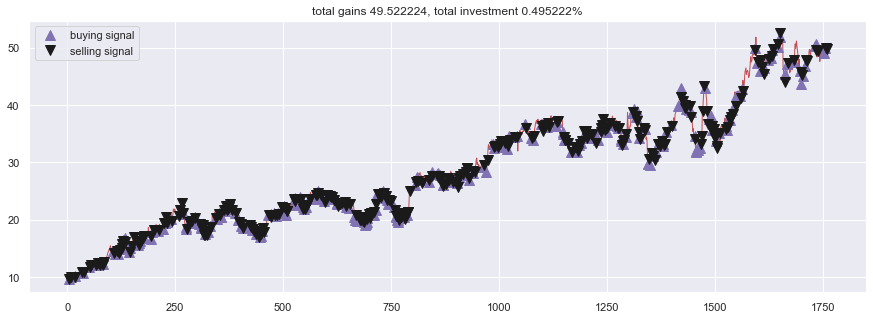

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()